# 0. Library

In [ ]:
# 0. Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle  # For saving WOE bins
from datetime import datetime
import warnings

from sklearn.feature_selection import VarianceThreshold

# scorecardpy for WOE/IV
import scorecardpy as sc

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200) # Show more rows for IV list
pd.set_option('display.float_format', lambda x: '%.5f' % x)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning) # scorecardpy might raise this

# --- Configuration ---
PROCESSED_DATA_PATH = '../data/processed/'
OUTPUT_PATH = '../output/'
TARGET_VAR = 'TARGET'
UNIQUE_ID = 'SK_ID_CURR'

# Feature Selection Thresholds
VARIANCE_THRESHOLD_VALUE = 0.01 # Remove features with variance lower than this
CORRELATION_THRESHOLD_VALUE = 0.95 # Remove one feature from pairs with correlation higher than this
IV_THRESHOLD_VALUE = 0.02 # Keep features with Information Value higher than this (common minimum threshold)

# 1. Load Data

In [3]:
# 1. Load Processed Data
def load_processed_data(path):
    """Loads the final train and test CSV files generated by feature engineering."""
    print(f"Loading processed data from: {path}")
    try:
        train_df = pd.read_csv(path + 'train_final.csv')
        test_df = pd.read_csv(path + 'test_final.csv')
        print(f"Train shape: {train_df.shape}")
        print(f"Test shape: {test_df.shape}")
        return train_df, test_df
    except FileNotFoundError as e:
        print(f"Error loading files: {e}. Make sure 'train_final.csv' and 'test_final.csv' exist in {path}")
        raise

train_df, test_df = load_processed_data(PROCESSED_DATA_PATH)

Loading processed data from: ../data/processed/
Train shape: (246005, 775)
Test shape: (61502, 775)


# 2. Separate Target, ID, and Features

In [4]:
# 2. Separate Target, ID, and Features
print("Separating Target, ID, and Features...")

# Ensure target is present
if TARGET_VAR not in train_df.columns or TARGET_VAR not in test_df.columns:
     raise ValueError(f"Target variable '{TARGET_VAR}' not found in loaded data.")

y_train = train_df[TARGET_VAR]
y_test = test_df[TARGET_VAR]

# Keep IDs separate if needed later, but drop for feature selection steps
train_ids = train_df[UNIQUE_ID]
test_ids = test_df[UNIQUE_ID]

# Drop Target and ID from feature sets
X_train = train_df.drop(columns=[TARGET_VAR, UNIQUE_ID])
X_test = test_df.drop(columns=[TARGET_VAR, UNIQUE_ID])

# Align columns - crucial if FE resulted in different columns (shouldn't happen with this code structure)
train_cols = X_train.columns.tolist()
test_cols = X_test.columns.tolist()

if train_cols != test_cols:
    print("Warning: Train and test columns differ before selection. Aligning...")
    common_cols = list(set(train_cols) & set(test_cols))
    X_train = X_train[common_cols]
    X_test = X_test[common_cols]
    print(f"Aligned to {len(common_cols)} common columns.")

print(f"Initial feature count: {X_train.shape[1]}")

Separating Target, ID, and Features...
Initial feature count: 773


# 3. Variance Threshold

In [5]:
# 3. Apply Variance Threshold
# --- Note: Applies only to numeric features ---
print(f"\n--- Applying Variance Threshold ({VARIANCE_THRESHOLD_VALUE}) ---")

# Select only numeric columns for variance calculation
numeric_cols_train = X_train.select_dtypes(include=np.number).columns.tolist()
X_train_numeric = X_train[numeric_cols_train]
X_test_numeric = X_test[numeric_cols_train] # Use same columns for test

selector = VarianceThreshold(threshold=VARIANCE_THRESHOLD_VALUE)

# Fit on TRAINING data only
selector.fit(X_train_numeric)

# Get columns to keep
kept_cols_mask = selector.get_support()
kept_numeric_cols = X_train_numeric.columns[kept_cols_mask]
dropped_numeric_cols = X_train_numeric.columns[~kept_cols_mask]

print(f"Columns dropped by Variance Threshold ({len(dropped_numeric_cols)}):")
if len(dropped_numeric_cols) > 0:
    print(dropped_numeric_cols.tolist())
else:
    print("None")

# Keep only selected numeric columns + any non-numeric columns
non_numeric_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()
cols_after_vt = kept_numeric_cols.tolist() + non_numeric_cols

X_train_vt = X_train[cols_after_vt].copy()
X_test_vt = X_test[cols_after_vt].copy() # Apply same selection to test

print(f"Feature count after Variance Threshold: {X_train_vt.shape[1]}")


--- Applying Variance Threshold (0.01) ---
Columns dropped by Variance Threshold (231):
['REGION_POPULATION_RELATIVE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'ANNUITY_INCOME_RATIO', '

# 4. Correlation Filtering

In [6]:
# 4. Apply Correlation Filtering
print(f"\n--- Applying Correlation Filtering ({CORRELATION_THRESHOLD_VALUE}) ---")

# Calculate correlation matrix on numeric features of TRAINING data
# Identify numeric columns remaining after VT
numeric_cols_vt = X_train_vt.select_dtypes(include=np.number).columns.tolist()
corr_matrix = X_train_vt[numeric_cols_vt].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index pairs with correlation greater than threshold
to_drop_corr = set()
highly_correlated_pairs = []

for row_idx in range(len(upper.columns)):
    for col_idx in range(row_idx):
        if upper.iloc[col_idx, row_idx] > CORRELATION_THRESHOLD_VALUE:
            colname_row = upper.columns[row_idx]
            colname_col = upper.columns[col_idx]
            highly_correlated_pairs.append((colname_col, colname_row, upper.iloc[col_idx, row_idx]))

            # Compare variances (on training data)
            var_col = X_train_vt[colname_col].var()
            var_row = X_train_vt[colname_row].var()

            if var_col < var_row:
                to_drop_corr.add(colname_col)
                # print(f"Marking '{colname_col}' (var={var_col:.4f}) for removal due to correlation with '{colname_row}' (var={var_row:.4f})")
            else:
                to_drop_corr.add(colname_row)
                # print(f"Marking '{colname_row}' (var={var_row:.4f}) for removal due to correlation with '{colname_col}' (var={var_col:.4f})")

print(f"Found {len(highly_correlated_pairs)} pairs with absolute correlation > {CORRELATION_THRESHOLD_VALUE}")
print(f"Columns dropped by Correlation Filtering ({len(to_drop_corr)}):")
if len(to_drop_corr) > 0:
    print(sorted(list(to_drop_corr)))
else:
    print("None")

# Drop the identified columns from both train and test
X_train_corr = X_train_vt.drop(columns=list(to_drop_corr))
X_test_corr = X_test_vt.drop(columns=list(to_drop_corr))

print(f"Feature count after Correlation Filtering: {X_train_corr.shape[1]}")


--- Applying Correlation Filtering (0.9) ---
Found 631 pairs with absolute correlation > 0.9
Columns dropped by Correlation Filtering (281):
['AGE_EMPLOYED_DIFF_MEAN_AGG_NAME_CONTRACT_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE', 'AGE_EMPLOYED_DIFF_MIN_AGG_NAME_CONTRACT_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE', 'AGE_EMPLOYED_DIFF_MIN_AGG_OCCUPATION_TYPE_ORGANIZATION_TYPE', 'AMT_ANNUITY_MEAN_AGG_CODE_GENDER_FLAG_OWN_CAR_FLAG_OWN_REALTY', 'AMT_ANNUITY_MEAN_AGG_FLAG_OWN_CAR_FLAG_OWN_REALTY_NAME_INCOME_TYPE', 'AMT_ANNUITY_MEAN_AGG_NAME_EDUCATION_TYPE_NAME_INCOME_TYPE_OCCUPATION_TYPE', 'AMT_ANNUITY_MEAN_AGG_OCCUPATION_TYPE_ORGANIZATION_TYPE', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'APARTMENTS_SUM_AVG', 'APARTMENTS_SUM_MEDI', 'B_AMT_ANNUITY_MAX_CA_ACTIVE', 'B_AMT_ANNUITY_MAX_CA_BAD_DEBT', 'B_AMT_ANNUITY_MAX_CA_CLOSED', 'B_AMT_ANNUITY_MAX_CA_SOLD', 'B_AMT_ANNUITY_MAX_OVERALL', 'B_AMT_ANNUITY_MEAN_CA_ACTIVE', 'B_AMT_ANNUITY_MEAN_CA_SOLD', 'B_AMT_ANNUITY_MEAN_OVERALL', 'B_AMT_ANNUITY_STD

# 5. WOE and IV Calculation


--- Performing WOE Binning & IV Calculation ---
Starting WOE binning at: 2025-04-09 10:19:08.540885
[INFO] creating woe binning ...
Binning on 246005 rows and 262 columns in 00:03:25
Finished WOE binning at: 2025-04-09 10:22:34.486923. Duration: 0:03:25.946038

Information Value (IV) Summary:
                                          Variable      IV
0                              WEIGHTED_EXT_SOURCE 0.66836
1                                   EXT_SOURCE_MIN 0.51561
2                                   EXT_SOURCE_MAX 0.44660
3                                     EXT_SOURCE_3 0.34473
4                                     EXT_SOURCE_2 0.30263
..                                             ...     ...
256            B_AMT_CREDIT_SUM_DEBT_SUM_CA_CLOSED 0.00000
257       B_B_AMT_ANNUITY_CREDIT_RATIO_STD_OVERALL 0.00000
258  B_B_CNT_PROLONGED_MAX_OVERDUE_MUL_STD_OVERALL 0.00000
259             B_AMT_CREDIT_SUM_LIMIT_MIN_OVERALL 0.00000
260                B_B_CREDIT_DURATION_STD_CA_SOLD 0.000

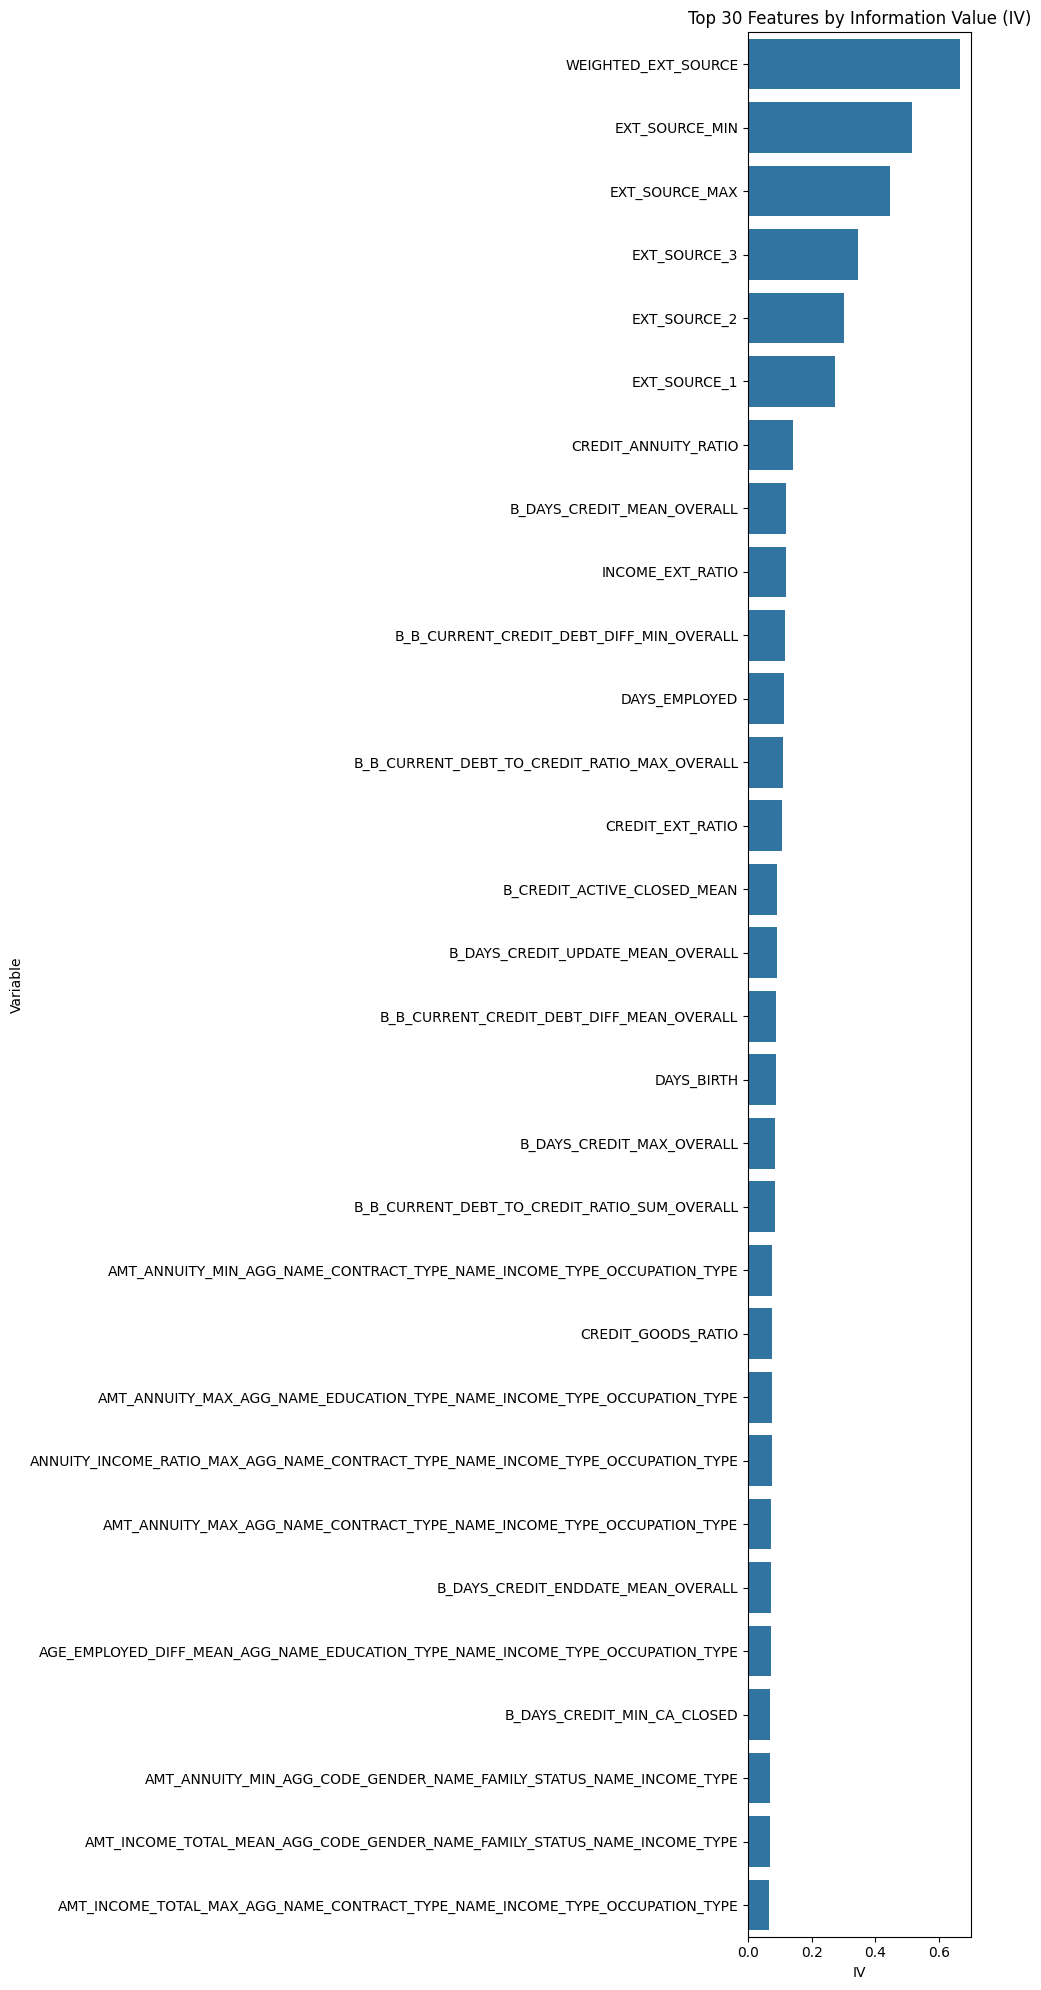

In [7]:
# 5. WOE Binning and IV Calculation using scorecardpy
print(f"\n--- Performing WOE Binning & IV Calculation ---")

# Combine features and target for scorecardpy functions
train_for_woe = pd.concat([X_train_corr, y_train], axis=1)

# Use scorecardpy's woebin function
# Adjust parameters as needed:
# - bin_num_limit: Max number of bins for numerical features
# - min_perc_fine_bin / min_perc_coarse_bin: Control bin size percentages
# - method: 'chimerge', 'tree', 'step' (chimerge is often good)
# - positive: Specify the positive class label format ('TARGET|1' means TARGET=1 is positive)

start_woe_time = datetime.now()
print(f"Starting WOE binning at: {start_woe_time}")

# Note: This can be computationally intensive for many features
bins = sc.woebin(train_for_woe, y=TARGET_VAR, positive=f'{TARGET_VAR}|1',
                 method='chimerge', # or 'tree'
                 bin_num_limit=10, # Max bins for numerical vars
                 min_perc_fine_bin=0.02, # Min % in initial fine bins
                 min_perc_coarse_bin=0.05, # Min % in final coarse bins
                 stop_limit=0.1, # Minimum IV improvement for splitting
                 no_cores= -1 # Use all available CPU cores
                )

end_woe_time = datetime.now()
print(f"Finished WOE binning at: {end_woe_time}. Duration: {end_woe_time - start_woe_time}")

# Extract IV information into a DataFrame
iv_list = []
for key, df in bins.items():
    # Check if 'total_iv' is directly in the df or calculate if needed (depends on scorecardpy version)
    if 'total_iv' in df.columns:
         # Handle cases where total_iv might be duplicated (take first)
         iv_value = df['total_iv'].iloc[0] if not pd.isna(df['total_iv'].iloc[0]) else 0
         iv_list.append({'Variable': key, 'IV': iv_value})
    # Older versions might store IV differently, adapt if necessary
    # else:
    #    # Example calculation if 'iv' is per bin: sum the 'iv' column
    #    if 'iv' in df.columns:
    #        iv_value = df['iv'].sum()
    #        iv_list.append({'Variable': key, 'IV': iv_value})

iv_df = pd.DataFrame(iv_list).sort_values(by='IV', ascending=False).reset_index(drop=True)

print("\nInformation Value (IV) Summary:")
print(iv_df)

# Visualize top N IV features
plt.figure(figsize=(10, max(5, min(20, len(iv_df)//2)))) # Adjust height based on number of features
sns.barplot(y='Variable', x='IV', data=iv_df.head(30)) # Show top 30
plt.title('Top 30 Features by Information Value (IV)')
plt.tight_layout()
plt.show()

# Optional: Plot WOE for a specific variable
# sc.woebin_plot(bins['EXT_SOURCE_MEAN']) # Example

# 6. IV Feature Selection

In [8]:
# 6. IV-Based Feature Selection
print(f"\n--- Selecting Features based on IV Threshold ({IV_THRESHOLD_VALUE}) ---")

selected_features_iv = iv_df[iv_df['IV'] >= IV_THRESHOLD_VALUE]['Variable'].tolist()
dropped_features_iv = iv_df[iv_df['IV'] < IV_THRESHOLD_VALUE]['Variable'].tolist()

print(f"Selected {len(selected_features_iv)} features based on IV >= {IV_THRESHOLD_VALUE}")
print(f"Dropped {len(dropped_features_iv)} features based on IV < {IV_THRESHOLD_VALUE}:")
if len(dropped_features_iv) > 0:
    print(dropped_features_iv)
else:
    print("None")

# Filter train and test sets to keep only selected features
X_train_iv = X_train_corr[selected_features_iv].copy()
X_test_iv = X_test_corr[selected_features_iv].copy()

print(f"\nFeature count after IV Selection: {X_train_iv.shape[1]}")


--- Selecting Features based on IV Threshold (0.02) ---
Selected 112 features based on IV >= 0.02
Dropped 149 features based on IV < 0.02:
['AMT_INCOME_TOTAL_MIN_AGG_CODE_GENDER_NAME_FAMILY_STATUS_NAME_INCOME_TYPE', 'B_DAYS_CREDIT_MIN_CA_ACTIVE', 'AMT_ANNUITY_MAX_AGG_FLAG_OWN_CAR_FLAG_OWN_REALTY_NAME_INCOME_TYPE', 'B_B_CURRENT_DEBT_TO_CREDIT_RATIO_MIN_OVERALL', 'FLAG_CONTACTS_SUM', 'FLOORSMIN_MEDI', 'B_BB_MONTHS_BALANCE_POS_COUNT_MEAN_CA_ACTIVE', 'B_BB_MONTHS_BALANCE_POS_MAX_MAX_OVERALL', 'B_AMT_CREDIT_SUM_MIN_OVERALL', 'B_AMT_CREDIT_SUM_DEBT_MIN_OVERALL', 'SUM_FLAGS_DOCUMENTS', 'B_AMT_CREDIT_SUM_SUM_OVERALL', 'LIVE_CITY_NOT_WORK_CITY', 'YEARS_BUILD_MODE', 'B_AMT_CREDIT_SUM_DEBT_MEAN_CA_ACTIVE', 'FLAG_DOCUMENT_6', 'B_BB_MONTHS_BALANCE_POS_MAX_MIN_OVERALL', 'B_CREDIT_TYPE_CREDIT CARD_MEAN', 'B_AMT_CREDIT_MAX_OVERDUE_SUM_OVERALL', 'OBS_DEF_30_MUL', 'DEF_30_60_SUM', 'CREDIT_INCOME_RATIO', 'B_CREDIT_CURRENCY_CURRENCY 1_MEAN', 'B_AMT_CREDIT_SUM_DEBT_SUM_OVERALL', 'AMT_ANNUITY_MAX_AGG_CODE_

# 7. WOE Transformation

In [ ]:
# # 7. WOE Transformation
# print(f"\n--- Applying WOE Transformation ---")

# # Apply the bins to transform train and test data
# # Important: Use the 'bins' dictionary generated from the TRAINING data

# # selected_features_iv should already be a list from cell 13
# # Create subset dataframes with only required columns
# train_for_woe = train_df[[UNIQUE_ID, TARGET_VAR] + selected_features_iv]
# test_for_woe = test_df[[UNIQUE_ID, TARGET_VAR] + selected_features_iv]

# # Apply WOE transformation
# train_woe = sc.woebin_ply(train_for_woe, bins=bins, positive=f'{TARGET_VAR}|1')
# test_woe = sc.woebin_ply(test_for_woe, bins=bins, positive=f'{TARGET_VAR}|1')

# # Rename columns to indicate WOE transformation
# woe_cols = {col: col + '_WOE' for col in selected_features_iv}
# train_woe = train_woe.rename(columns=woe_cols)
# test_woe = test_woe.rename(columns=woe_cols)

# # Separate features and target again for the WOE dataset
# X_train_woe = train_woe.drop(columns=[TARGET_VAR, UNIQUE_ID])
# y_train_woe = train_woe[TARGET_VAR] # Should be identical to y_train

# X_test_woe = test_woe.drop(columns=[TARGET_VAR, UNIQUE_ID])
# y_test_woe = test_woe[TARGET_VAR] # Should be identical to y_test

# print("WOE transformation applied.")
# print(f"Train WOE shape: {X_train_woe.shape}")
# print(f"Test WOE shape: {X_test_woe.shape}")
# print("\nExample WOE Transformed Data (Train Head):")
# print(X_train_woe.head())


--- Applying WOE Transformation ---
[INFO] converting into woe values ...


TypeError: unhashable type: 'numpy.ndarray'

# 8. Save Result

In [12]:
# 8. Save Results
print(f"\n--- Saving Feature Selection Results ---")

# --- Save List of Selected Features (Post-Correlation, Pre-IV/WOE) ---
# These are the features BEFORE WOE transformation, selected by VT and Corr
features_after_corr = X_train_corr.columns.tolist()
output_file_selected_corr = OUTPUT_PATH + 'features_selected_correlation.pkl'
with open(output_file_selected_corr, 'wb') as f:
    pickle.dump(features_after_corr, f)
print(f"Saved list of {len(features_after_corr)} features (post-VT/Corr) to: {output_file_selected_corr}")

# --- Save List of IV-Selected Features ---
# These are the names of features selected based on IV threshold
output_file_selected_iv = OUTPUT_PATH + 'features_selected_iv.pkl'
with open(output_file_selected_iv, 'wb') as f:
    pickle.dump(selected_features_iv, f)
print(f"Saved list of {len(selected_features_iv)} features (post-IV) to: {output_file_selected_iv}")

# --- Save WOE Bins Dictionary ---
# This dictionary is essential for applying WOE to new data later
output_file_woe_bins = OUTPUT_PATH + 'woe_bins.pkl'
with open(output_file_woe_bins, 'wb') as f:
    pickle.dump(bins, f)
print(f"Saved WOE bins dictionary to: {output_file_woe_bins}")

# --- Save WOE Transformed DataFrames ---
# These contain the features transformed into WOE values
output_file_train_woe = PROCESSED_DATA_PATH + 'train.csv'
output_file_test_woe = PROCESSED_DATA_PATH + 'test.csv'

# Include ID and Target for potential later use/analysis
pd.concat([train_ids.reset_index(drop=True), y_train.reset_index(drop=True), X_train_iv.reset_index(drop=True)], axis=1).to_csv(output_file_train_woe, index=False, mode='w+')
pd.concat([test_ids.reset_index(drop=True), y_test.reset_index(drop=True), X_test_iv.reset_index(drop=True)], axis=1).to_csv(output_file_test_woe, index=False, mode='w+')
print(f"Saved WOE transformed train data to: {output_file_train_woe}")
print(f"Saved WOE transformed test data to: {output_file_test_woe}")

print("\nFeature Selection and WOE Transformation Complete.")


--- Saving Feature Selection Results ---
Saved list of 261 features (post-VT/Corr) to: ../output/features_selected_correlation.pkl
Saved list of 112 features (post-IV) to: ../output/features_selected_iv.pkl
Saved WOE bins dictionary to: ../output/woe_bins.pkl
Saved WOE transformed train data to: ../data/processed/train.csv
Saved WOE transformed test data to: ../data/processed/test.csv

Feature Selection and WOE Transformation Complete.
